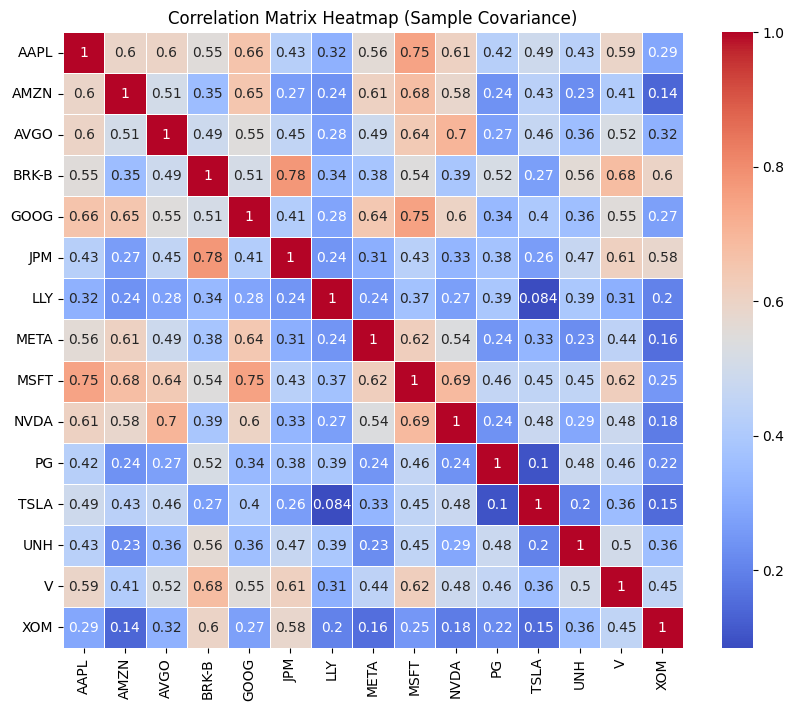

<Figure size 640x480 with 0 Axes>

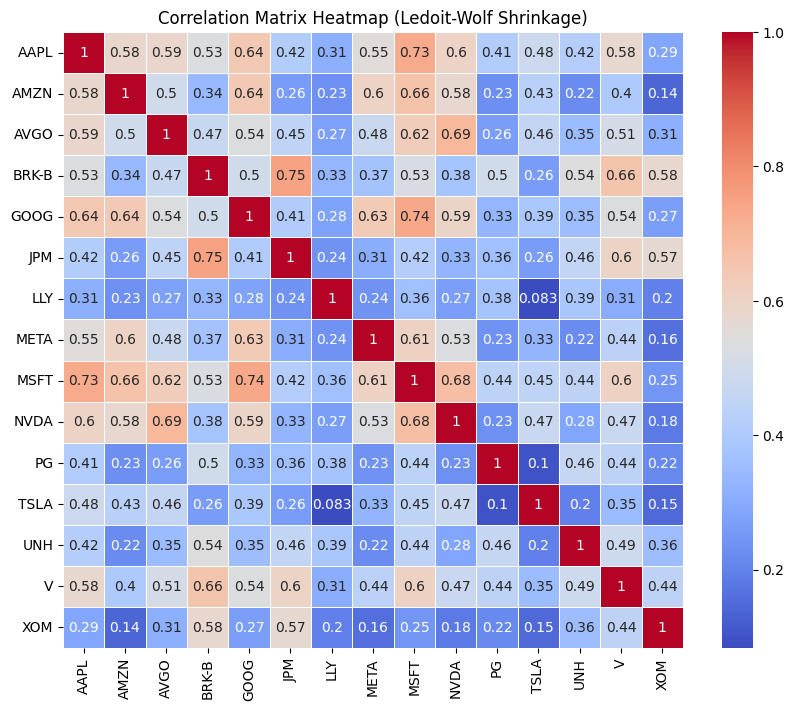

<Figure size 640x480 with 0 Axes>

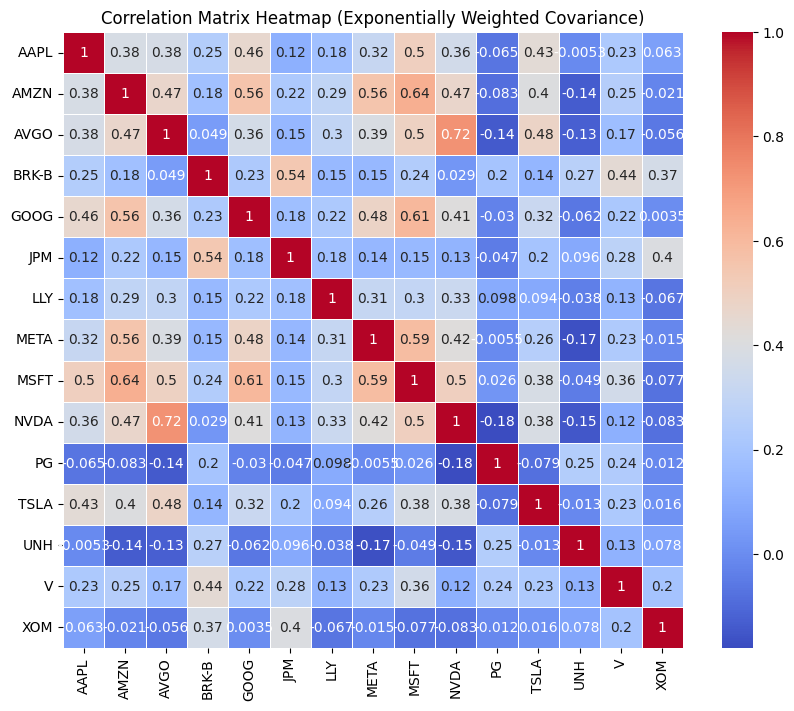

<Figure size 640x480 with 0 Axes>

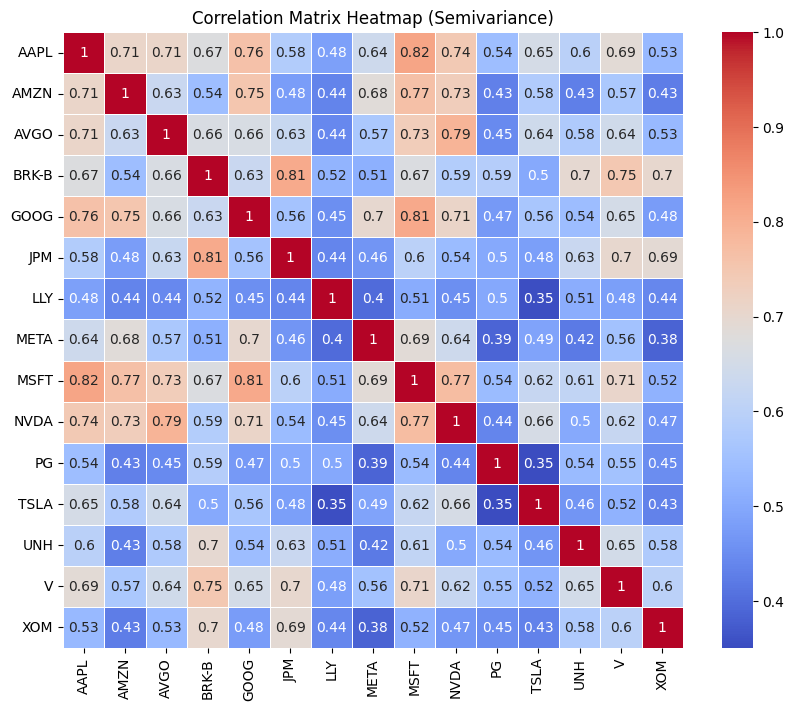

<Figure size 640x480 with 0 Axes>

In [10]:
'''
Correlation and covariance matrices.
Various methods for comparative purposes. 
'''

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier

# Load prices
prices = pd.read_csv('combined_eod_data_tiingo.csv')

# Set the 'date' column as the index
prices.set_index('date', inplace=True)

# Calculate daily percentage changes
returns = prices.pct_change(fill_method=None)
returns.dropna(inplace=True)

# Calculate covariance matrices using different methods
cov_matrix = returns.cov() * 252 # manual calc, equal result to sample_cov
cov_pfopt = risk_models.sample_cov(prices, frequency=252)
cov_ledoit = risk_models.CovarianceShrinkage(prices, frequency=252).ledoit_wolf()
cov_exp = risk_models.exp_cov(prices, frequency=252, span=252, log_returns=True)
semivarcov = risk_models.semicovariance(prices, benchmark=0.0, frequency=252)


# Convert covariance matrices to correlation matrices
def calculate_correlation(cov_matrix):
    variances = np.diag(cov_matrix) 
    std_dev = np.sqrt(variances)
    sd_df = pd.Series(std_dev, index=cov_matrix.index)

    # Divide by sd. to get correlation
    corr_matrix = cov_matrix.divide(sd_df, axis=0)  
    corr_matrix = corr_matrix.divide(sd_df, axis=1)

    return corr_matrix

corr_cov_pfopt = calculate_correlation(cov_pfopt)
corr_cov_ledoit = calculate_correlation(cov_ledoit)
corr_cov_exp = calculate_correlation(cov_exp)
cor_semicov = risk_models.cov_to_corr(semivarcov)
# print(cor_semicov)
# corr_cov_exp = risk_models.cov_to_corr(cov_exp) # JR: Less intuitive and gives an almost identical output.  


# Plotting the correlation matrices as heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_pfopt, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Sample Covariance)')
plt.show()
plt.savefig('correlation_heatmap.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_ledoit, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Ledoit-Wolf Shrinkage)')
plt.show()
plt.savefig('correlation_heatmap_ledoit.png')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_cov_exp, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Exponentially Weighted Covariance)')
plt.show()
plt.savefig('correlation_heatmap_exp.png')

plt.figure(figsize=(10, 8))
sns.heatmap(cor_semicov, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap (Semivariance)')
plt.show()
plt.savefig('correlation_heatmap_exp.png')



In [ ]:
'''
Additional output comparisons - using capm returns function and exp_cov to check outputs.
'''


risk = risk_models.risk_matrix(prices, method='exp_cov')
# print (risk)

capm_returns = expected_returns.ema_historical_return(prices)
print(capm_returns)
historic_returns = expected_returns.mean_historical_return(prices)
print(historic_returns)

max_weight = (1 / len(prices.columns)) * 2
# print(max_weight)

# Standard MVO, optimised for Sharpe Ratio with CAPM
ef_capm = EfficientFrontier(capm_returns, cov_matrix, weight_bounds=(0.01, max_weight))
weights = ef_capm.max_sharpe()
weights = ef_capm.clean_weights()
print(weights)
ef_capm.portfolio_performance(verbose=True)

# Standard MVO, optimised for Sharpe Ratio
ef = EfficientFrontier(historic_returns, cov_matrix, weight_bounds=(0.01, max_weight))
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)
ef.portfolio_performance(verbose=True)

# MVO, optimised for minimum volatility
efmin = EfficientFrontier(historic_returns, cov_matrix, weight_bounds=(0.01, max_weight))
efmin.min_volatility()
weights = efmin.clean_weights()
print(weights)
efmin.portfolio_performance(verbose=True)





AAPL     0.344772
AMZN     0.298219
AVGO     0.944711
BRK-B    0.273159
GOOG     0.260007
JPM      0.322219
LLY      0.643022
META     0.798238
MSFT     0.259368
NVDA     1.630518
PG       0.155661
TSLA     0.499792
UNH      0.210203
V        0.133391
XOM      0.200867
Name: 2024-09-30, dtype: float64
AAPL     0.339379
AMZN     0.165367
AVGO     0.487161
BRK-B    0.172436
GOOG     0.224616
JPM      0.157356
LLY      0.534782
META     0.264287
MSFT     0.265554
NVDA     0.949941
PG       0.095435
TSLA     0.748979
UNH      0.237356
V        0.106262
XOM      0.162859
dtype: float64
OrderedDict({'AAPL': 0.01, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13333, 'GOOG': 0.01, 'JPM': 0.06363, 'LLY': 0.13333, 'META': 0.13333, 'MSFT': 0.01, 'NVDA': 0.13333, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.02618, 'V': 0.01, 'XOM': 0.05019})
Expected annual return: 64.7%
Annual volatility: 24.1%
Sharpe Ratio: 2.60
OrderedDict({'AAPL': 0.04182, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13299, 'GOOG': 0.01, 'J

(0.23135126988671556, 0.19744611490097358, 1.0704250625175173)

In [ ]:
'''
Optimisations, using daily prices. 
'''
import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance

# JR - note that once this is combined, the below will be unnecessary, repeated for ease of debugging.

# Load prices
prices = pd.read_csv('combined_eod_data_tiingo.csv')
prices.set_index('date', inplace=True)

# Calculate daily and expected returns from above
returns = prices.pct_change().dropna()
# print(returns)
mu = expected_returns.mean_historical_return(prices)  
cov_matrix = risk_models.sample_cov(prices)           
print(mu)

# Other variables
risk_free_rate = 0.02
assets = len(prices.columns)
max_weight = (1 / assets) * 2
stock_ew = round(1 / assets, 5)

# Optimisations: 

# Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
equal_weight_dict = {ticker: stock_ew for ticker in prices.columns}
print(equal_weight_dict)

# Equal weights ratios
ew_return = np.dot(ew, mu)
ew_vol = np.sqrt(np.dot(ew.T, np.dot(cov_matrix, ew)))
ew_sharpe = (ew_return - risk_free_rate) / ew_vol

print(f"Equal Weighted Portfolio:")
print(f"Expected Return: {ew_return:.2%}")
print(f"Volatility: {ew_vol:.2%}")
print(f"Sharpe Ratio: {ew_sharpe:.2f}")

# Max Sharpe Ratio Portfolio
ef = EfficientFrontier(mu, cov_matrix, weight_bounds=(0.01, max_weight))
ef.max_sharpe(risk_free_rate=risk_free_rate)
max_sharpe_weights = ef.clean_weights()
max_sharpe_weights = {ticker: round(weight, 5) for ticker, weight in max_sharpe_weights.items()}
print(f"Max Sharpe Portfolio:")
print(max_sharpe_weights)
max_sharpe_performance = ef.portfolio_performance(verbose=True)

# Minimum Volatility Portfolio
ef = EfficientFrontier(mu, cov_matrix, weight_bounds=(0.01, max_weight))
ef.min_volatility()
min_vol_weights = ef.clean_weights()
min_vol_weights = {ticker: round(weight, 5) for ticker, weight in min_vol_weights.items()}
print(f"Minimum Vol Portfolio:")
print(min_vol_weights)
min_vol_performance = ef.portfolio_performance(verbose=True)




# PostModernPortfolioTheory - Max Sortino Portfolio
# TODO



# Mean Semivariance Optimisation - Minimise semivariance



# Combine to dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weights (%)')
max_sharpe_series = pd.Series(max_sharpe_weights, name='Max Sharpe Weights (%)')
min_vol_series = pd.Series(min_vol_weights, name='Minimum Vol Weights (%)')
weights_df = pd.concat([ew_series, max_sharpe_series, min_vol_series], axis=1)
print(weights_df)



# Create full output in Openpyxl
# TODO




AAPL     0.339379
AMZN     0.165367
AVGO     0.487161
BRK-B    0.172436
GOOG     0.224616
JPM      0.157356
LLY      0.534782
META     0.264287
MSFT     0.265554
NVDA     0.949941
PG       0.095435
TSLA     0.748979
UNH      0.237356
V        0.106262
XOM      0.162859
dtype: float64
{'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667}
Equal Weighted Portfolio:
Expected Return: 32.75%
Volatility: 24.02%
Sharpe Ratio: 1.28
Max Sharpe Portfolio:
{'AAPL': 0.04182, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.13299, 'GOOG': 0.01, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.13333, 'PG': 0.07662, 'TSLA': 0.13333, 'UNH': 0.13333, 'V': 0.01, 'XOM': 0.02191}
Expected annual return: 45.4%
Annual volatility: 25.9%
Sharpe Ratio: 1.68
Minimum Vol Portfolio:
{'AAPL': 0.01, 'AMZN': 0.12677

In [8]:
'''
Adjusting the above to work with monthly returns.
Work in progress
'''

import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance

# Load prices
prices = pd.read_csv('combined_eod_data_tiingo.csv')
prices.set_index('date', inplace=True)
prices.index = pd.to_datetime(prices.index)

# Calculate monthly prices and returns
monthly_prices = prices.resample('ME').last()  # Resample to get monthly prices
monthly_returns = monthly_prices.pct_change().dropna()
# print(monthly_returns)

# Calculate expected returns and covariance matrix for monthly data
mu_monthly = expected_returns.mean_historical_return(monthly_prices, frequency=12)
cov_matrix_monthly = risk_models.sample_cov(monthly_prices, frequency=12)
print(mu_monthly)

# Other variables
annual_risk_free = 0.02 # standard default
monthly_risk_free = (1+annual_risk_free) ** (1/12) - 1
assets = len(prices.columns)
max_weight = (1 / assets) * 2
stock_ew = round(1 / assets, 5)

# Equal Weighted Portfolio
ew = np.array([1/assets] * assets)
equal_weight_dict = {ticker: stock_ew for ticker in prices.columns}
print(equal_weight_dict)

# Equal weights ratios
ew_return = np.dot(ew, mu_monthly)
ew_vol = np.sqrt(np.dot(ew.T, np.dot(cov_matrix_monthly, ew)))
ew_sharpe = (ew_return - annual_risk_free) / ew_vol

print(f"Equal Weighted Portfolio (Monthly):")
print(f"Expected Return: {ew_return:.2%}")
print(f"Volatility: {ew_vol:.2%}")
print(f"Sharpe Ratio: {ew_sharpe:.2f}")

# Max Sharpe Ratio Portfolio
ef_monthly = EfficientFrontier(mu_monthly, cov_matrix_monthly, weight_bounds=(0.01, max_weight))
ef_monthly.max_sharpe(risk_free_rate=annual_risk_free)
max_sharpe_weights_monthly = ef_monthly.clean_weights()
max_sharpe_weights_monthly = {ticker: round(weight, 5) for ticker, weight in max_sharpe_weights_monthly.items()}
print(f"Max Sharpe Portfolio (Monthly):")
print(max_sharpe_weights_monthly)
max_sharpe_performance_monthly = ef_monthly.portfolio_performance(verbose=True, risk_free_rate=annual_risk_free)

# Minimum Volatility Portfolio
ef_monthly = EfficientFrontier(mu_monthly, cov_matrix_monthly, weight_bounds=(0.01, max_weight))
ef_monthly.min_volatility()
min_vol_weights_monthly = ef_monthly.clean_weights()
min_vol_weights_monthly = {ticker: round(weight, 5) for ticker, weight in min_vol_weights_monthly.items()}
print(f"Minimum Vol Portfolio (Monthly):")
print(min_vol_weights_monthly)
min_vol_performance_monthly = ef_monthly.portfolio_performance(verbose=True,risk_free_rate=annual_risk_free)

# PMPT - Optimise for Sortino Ratio




# Semi Variance Optimisation

ret_monthly = expected_returns.mean_historical_return(monthly_prices, frequency=12)
svo_historic_returns = expected_returns.returns_from_prices(monthly_prices)
print(svo_historic_returns)


svo = EfficientSemivariance(ret_monthly, svo_historic_returns,weight_bounds=(0.01, max_weight))
svo.efficient_return(target_return=0.06)
# svo.min_semivariance()
svoweights = svo.clean_weights()
print(svoweights)
svo.portfolio_performance(verbose=True)



# Combine to dataframe
ew_series = pd.Series(equal_weight_dict, name='Equal Weights (%)')
max_sharpe_series = pd.Series(max_sharpe_weights_monthly, name='Max Sharpe Weights (Monthly) (%)')
min_vol_series = pd.Series(min_vol_weights_monthly, name='Min Vol Weights (Monthly) (%)')
svo_series = pd.Series(svoweights, name="Min Semivariance (Monthly)")
weights_df = pd.concat([ew_series, max_sharpe_series, min_vol_series, svo_series], axis=1)
print(weights_df)

# Create full output in Openpyxl
# TODO


AAPL     0.338744
AMZN     0.165084
AVGO     0.486242
BRK-B    0.172140
GOOG     0.224226
JPM      0.157192
LLY      0.533718
META     0.263814
MSFT     0.265094
NVDA     0.947882
PG       0.095326
TSLA     0.747428
UNH      0.236904
V        0.106120
XOM      0.162699
dtype: float64
{'AAPL': 0.06667, 'AMZN': 0.06667, 'AVGO': 0.06667, 'BRK-B': 0.06667, 'GOOG': 0.06667, 'JPM': 0.06667, 'LLY': 0.06667, 'META': 0.06667, 'MSFT': 0.06667, 'NVDA': 0.06667, 'PG': 0.06667, 'TSLA': 0.06667, 'UNH': 0.06667, 'V': 0.06667, 'XOM': 0.06667}
Equal Weighted Portfolio (Monthly):
Expected Return: 32.68%
Volatility: 20.40%
Sharpe Ratio: 1.50
Max Sharpe Portfolio (Monthly):
{'AAPL': 0.03474, 'AMZN': 0.01, 'AVGO': 0.13333, 'BRK-B': 0.0102, 'GOOG': 0.01, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.08955, 'NVDA': 0.13333, 'PG': 0.13333, 'TSLA': 0.03479, 'UNH': 0.13333, 'V': 0.01, 'XOM': 0.11405}
Expected annual return: 39.8%
Annual volatility: 18.7%
Sharpe Ratio: 2.02
Minimum Vol Portfolio (Monthly)

In [ ]:
'''
Mean Semivariance. 
"The firsti00010
 is to use a heuristic (i.e “quick and dirty”) solution: 
pretending that the semicovariance matrix (implemented in risk_models) 
is a typical covariance matrix and doing standard mean-variance optimization. 
It can be shown that this does not yield a portfolio that is efficient 
in mean-semivariance space (though it might be a good-enough approximation).
Estrada.
'''



import pandas as pd
import numpy as np
from pypfopt import risk_models, expected_returns, EfficientFrontier, EfficientSemivariance

# Load prices
prices = pd.read_csv('combined_eod_data_tiingo.csv')
prices.set_index('date', inplace=True)
prices.index = pd.to_datetime(prices.index)

ret_monthly = expected_returns.mean_historical_return(prices, frequency=252)
svo_historic_returns = expected_returns.returns_from_prices(prices)

svo = EfficientSemivariance(ret_monthly, svo_historic_returns,weight_bounds=(0.01, max_weight))
svo.efficient_return(0.08)
svoweights = svo.clean_weights()
print(svoweights)
svo.portfolio_performance(verbose=True)


OrderedDict({'AAPL': 0.01, 'AMZN': 0.13123, 'AVGO': 0.01, 'BRK-B': 0.13333, 'GOOG': 0.01171, 'JPM': 0.01, 'LLY': 0.13333, 'META': 0.01, 'MSFT': 0.01, 'NVDA': 0.01, 'PG': 0.13333, 'TSLA': 0.01, 'UNH': 0.13333, 'V': 0.12362, 'XOM': 0.1301})
Expected annual return: 22.9%
Annual semi-deviation: 13.6%
Sortino Ratio: 1.54


(0.2294724664341962, 0.1362879301014119, 1.5369847225526696)